### Topic Modeling

In [1]:
#load libraries
import pandas as pd
import numpy as np

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Gensim
from gensim.models import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

#for plotting
import matplotlib.pyplot as plt


c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
#for checking convergence of model
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
#
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

In [3]:
#load cleaned data from csv
df = pd.read_csv('data/cleaned_data.csv',dtype=str)
df['amount'].astype(float, errors='ignore')

print(df.head(5))
print(f"shape is: {df.shape}")

  award_id                                              title    amount  \
0  0000009     Design of Cutting Tools for High Speed Milling  280000.0   
1  0000026  A Novel Ultrasonic Cooling Concept for Microel...  292026.0   
2  0000027  Development of a Wireless Sensor to Detect Cra...  238000.0   
3  0000031  Development of Link-to-Column Connections for ...  285000.0   
4  0000033  Integrated study of source, path, and site eff...   84000.0   

                                            abstract  \
0  this project will focus development new cuttin...   
1  the purpose the proposed work design novel coo...   
2  &lt;br/&gt;the objective this research project...   
3  &lt;br/&gt;engelhardt&lt;br/&gt;the objective ...   
4  the kocaeli, turkey, earthquake (m=.) august w...   

                                   division  
0  Div Of Civil, Mechanical, & Manufact Inn  
1     Div Of Electrical, Commun & Cyber Sys  
2  Div Of Civil, Mechanical, & Manufact Inn  
3  Div Of Civil, Mechanical,

In [5]:
df['division'].value_counts()

Division Of Mathematical Sciences           18567
Translational Impacts                       12728
Division Of Computer and Network Systems    12199
Div Of Civil, Mechanical, & Manufact Inn    11904
Division Of Earth Sciences                  11573
                                            ...  
Division Of Information Systems                 1
General Counsel                                 1
Office Of The Director                          1
Natl Nanotechnology Coordinating Office         1
Division Of Design & Manufacturing Innov        1
Name: division, Length: 73, dtype: int64

In [6]:
#zoom in on one division
division = 'Div Of Civil, Mechanical, & Manufact Inn'
# division = 'Division Of Mathematical Sciences'

#filter data by division
data = df[df['division']==division]

In [7]:
#add year column
data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")

<ipython-input-7-3b36e28d5732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")


In [8]:
#reset index
data.reset_index(inplace=True,drop=True)

We will preprocess the entire corpus and handle the representation (BoW) in a single go. That way, we won't have to worry about inconsistent representations among models.

In [9]:
#convert to list
text_data = data['abstract'].tolist()

In [10]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(text_data)):
    text_data[idx] = text_data[idx].lower()  
    text_data[idx] = tokenizer.tokenize(text_data[idx])  # Split into words.

#remove numbers
text_data = [[token for token in doc if not token.isnumeric()] for doc in text_data]

#remove words that are only one character.
text_data = [[token for token in doc if len(token) > 1] for doc in text_data]

In [11]:
#look at first document
print(text_data[0][:25])

['this', 'project', 'will', 'focus', 'development', 'new', 'cutting', 'tool', 'designs', 'allow', 'increases', 'high', 'speed', 'machining', 'hsm', 'productivity', 'the', 'researchers', 'will', 'investigate', 'new', 'method', 'increasing', 'the', 'damping']


In [12]:
lemmatizer = WordNetLemmatizer()
text_data = [[lemmatizer.lemmatize(token) for token in doc] for doc in text_data]

In [13]:
#remove stop words
stop_words = stopwords.words('english')

#extend stop words to corpus specific words
extra_stop_words = ['award','project','research',
                    'investigator','investigators',
                    'investigate','investigates','investigated','investigating',
                    'proposal','proposals','abstract',
                    'nsf','funded','funding',
                    'program','programs',
                    'support','supports','supported',
                    'br','lt','gt','amp','quot','div','lf', #html tags
                    'pi','pis', #principal investigator]
                    'researcher','researchers',
                    'work','works','working',
                    'study','studies','studying',
                    'develop','develops','developed','developing','development',
                    'consider','considered','considering',
                    'include','includes','including',
                    'provide','provides','provided',
                    'use','uses','used',
                    'design','designs','designed','designing',
                    'demonstrate','demonstrates','demonstrated','demonstrating',
                    'result','results','resulted','resulting',
                    'show','shows','showed','showing',
                    'understand','understands','understood','understanding',
                    'determine','determines','determined','determining',
                    'find','finds','found','finding',
                    'identify','identifies','identified','identifying',
                    'evaluate','evaluates','evaluated','evaluating',
                    'examine','examines','examined','examining',
                    'explore','explores','explored','exploring',
                    'new','using','high','low','large','small','different','based',
                    'significant','important','possible','potential','novel',
                    'approach','approaches','approached','approaching',
                    'method','methods',
                    'include','includes','including',
                    'also','well','many','much','several','various','different',
                    'engineering','engineer','engineers','engineered',
                    'system','systems','systematic',
                    'model','models','modeling','modelled','modelled',
                    'analysis','analyse','analyses','analysed','analysing',
                    'method','methods','methodology','methodologies',
                    'specific','specifically',
                    'impact','impacts','impacted','impacting',
                    'profound','profoundly',
                    'significant','significantly',
                    'although','though','however','yet','still','nevertheless',
                    'thus','therefore','hence','consequently',
                    'first','second','third','fourth','fifth','sixth','seventh','eighth','ninth','tenth',
                    'have','has','having','had','ha',
                    'problem','problems',
                    'science','sciences','scientific',
                    'scientist','scientists',
                    'knowledge','knowledges','knowledgable',
]
stop_words.extend(extra_stop_words)

#much faster to convert to set
stop_words = set(stop_words)

In [14]:
#remove stop words
text_data = [[token for token in doc if token not in stop_words] for doc in text_data]

In [15]:
print(text_data[35])

['material', 'failure', 'strain', 'rate', 'batra', 'virginia', 'polytechnic', 'institute', 'state', 'university', 'hyperbolic', 'heat', 'equation', 'along', 'equation', 'expressing', 'balance', 'mass', 'linear', 'momentum', 'moment', 'momentum', 'thermoviscoplastic', 'material', 'delineate', 'initiation', 'propagation', 'adiabatic', 'shear', 'band', 'asbs', 'strain', 'rate', 'deformation', 'material', 'asb', 'narrow', 'region', 'intense', 'plastic', 'deformation', 'usually', 'precedes', 'ductile', 'failure', 'metal', 'polymer', 'deformed', 'strain', 'rate', 'heat', 'generated', 'due', 'plastic', 'deformation', 'material', 'heat', 'conduction', 'thermal', 'stress', 'induced', 'accounted', 'finite', 'element', 'mesh', 'refined', 'adaptively', 'time', 'increment', 'integrate', 'coupled', 'nonlinear', 'ordinary', 'differential', 'equation', 'obtained', 'galerkin', 'approximation', 'governing', 'equation', 'adjusted', 'adaptively', 'compute', 'stable', 'solution', 'within', 'prescribed', 'a

In [16]:
#look at most frequent words in data
from collections import Counter
from itertools import chain
from nltk import FreqDist

#flatten list of lists
all_words = list(chain(*text_data))


In [17]:
all_words_freq = FreqDist(all_words)

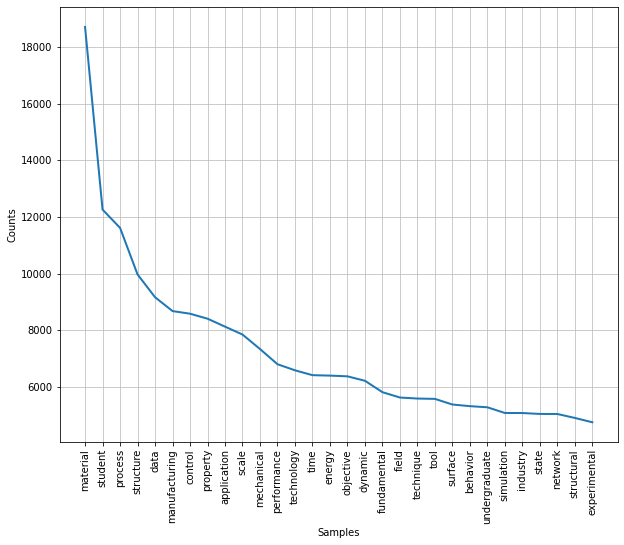

In [18]:
#plot most frequent words
plt.figure(figsize=(10,8))
all_words_freq.plot(30, cumulative=False)

#increase font size for plot
plt.rcParams.update({'font.size': 15})

In [19]:
#bigrams and trigrams. let's us capture useful phrases such as 'machine_learning' or 'quantum_computing'
bigram = Phrases(text_data, min_count=5, threshold=50) 
trigram = Phrases(bigram[text_data], threshold=50) 

# exporting trained models for bigrams and trigrams. faster.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [20]:
#see example of bigrams + trigrams
print([x for x in bigram_mod[text_data[7]] if '_' in x])

print([x for x in trigram_mod[text_data[7]] if '_' in x])

['titanium_alloy', 'nickel_superalloys', 'taking_account', 'thermo_mechanical', 'thermo_mechanical', 'titanium_alloy', 'aircraft_automobile', 'woman_minority']
['shear_localization', 'titanium_alloy', 'nickel_superalloys', 'taking_account', 'shear_localization', 'thermo_mechanical', 'thermo_mechanical', 'speed_spindle', 'titanium_alloy', 'aircraft_automobile', 'graduate_undergraduate', 'woman_minority']


In [21]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [22]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in text_data]

In [23]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6083
Number of documents: 11904


In [24]:
ntopics = 50
#train model on portion of the corpus
def train_model(corpus, id2word, num_topics=ntopics,):
    lda = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=2000,
            alpha='auto',
            eta='auto',
            iterations=500,
            num_topics=num_topics,
            passes=20,
            eval_every=1
        )
    return lda

In [25]:
#split corpus by year
corpus_by_year = {}
for year in data['year'].unique():
    corpus_by_year[year] = [corpus[i] for i in data[data['year']==year].index]

In [26]:
# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [27]:
#train model on a single year as a test #check for convergence. if it doesn't converge, increase iterations, extend stopwords, etc.
# model = train_model(corpus_by_year['2019'],id2word)

In [28]:
#look at topics
# [x[1] for x in model.show_topics(num_topics=ntopics, num_words=10, log=False, formatted=True)]


In [29]:
# #### run this once if you are happy with the model.
# # #perform the training on full dataset
# lda_by_year = {}
# for year in sorted(data['year'].unique()):
#     print(f"training model for year: {year}")
#     lda_by_year[year] = train_model(corpus_by_year[year],id2word,num_topics=50)

#     print(f"saving model for year: {year}")
#     lda_by_year[year].save(f'models/{division}_{year}.model')

# # #save dictionary
# dictionary.save_as_text('models/dictionary.txt')

training model for year: 2000
saving model for year: 2000
training model for year: 2001
saving model for year: 2001
training model for year: 2002
saving model for year: 2002
training model for year: 2003
saving model for year: 2003
training model for year: 2004
saving model for year: 2004
training model for year: 2005
saving model for year: 2005
training model for year: 2006
saving model for year: 2006
training model for year: 2007
saving model for year: 2007
training model for year: 2008
saving model for year: 2008
training model for year: 2009
saving model for year: 2009
training model for year: 2010
saving model for year: 2010
training model for year: 2011
saving model for year: 2011
training model for year: 2012
saving model for year: 2012
training model for year: 2013
saving model for year: 2013
training model for year: 2014
saving model for year: 2014
training model for year: 2015
saving model for year: 2015
training model for year: 2016
saving model for year: 2016
training model

In [30]:
# #load in pretrained models - after training
lda_by_year = {}
for year in sorted(data['year'].unique()):
    print(f"loading model for year: {year}")
    lda_by_year[year] = LdaModel.load(f'models/{division}_{year}.model')

loading model for year: 2000
loading model for year: 2001
loading model for year: 2002
loading model for year: 2003
loading model for year: 2004
loading model for year: 2005
loading model for year: 2006
loading model for year: 2007
loading model for year: 2008
loading model for year: 2009
loading model for year: 2010
loading model for year: 2011
loading model for year: 2012
loading model for year: 2013
loading model for year: 2014
loading model for year: 2015
loading model for year: 2016
loading model for year: 2017
loading model for year: 2018
loading model for year: 2019
loading model for year: 2020
loading model for year: 2021


Now that we've got topic models, we need to find a way to compare topics. The problem with just lining up topics across years is that we technically need to solve a node-correspondence problem or use other alignment algorithms. We will try to avoid this by aggregating across all topics by year.

In [31]:
#compare topic 1 across years
topic = 1
for year in sorted(data['year'].unique()):
    print(f"year: {year}")
    print(lda_by_year[year].show_topic(topic))
    print('\n')   

year: 2000
[('technology', 0.014999899), ('solution', 0.014135201), ('control', 0.012503395), ('solid', 0.010541256), ('information', 0.0101144295), ('engine', 0.009297683), ('dissipation', 0.009276117), ('data', 0.009146139), ('nonlinear', 0.008376628), ('wavelet', 0.0069697043)]


year: 2001
[('process', 0.018591262), ('material', 0.016863644), ('corrosion', 0.009476167), ('structure', 0.008336829), ('fabrication', 0.00757903), ('tool', 0.0072468766), ('composite', 0.0064372714), ('technology', 0.0063942336), ('manufacturing', 0.0062800418), ('data', 0.0061338237)]


year: 2002
[('liquefaction', 0.019900214), ('field', 0.00961339), ('effect', 0.009422617), ('material', 0.008624407), ('application', 0.00840443), ('failure', 0.0075571826), ('air', 0.007511152), ('tissue', 0.007419875), ('structure', 0.006022795), ('ground', 0.005944201)]


year: 2003
[('sensor', 0.018758746), ('control', 0.014284434), ('technology', 0.007620322), ('performance', 0.0072480943), ('acoustic', 0.007131328)

Topic 1 is clearly different among the years

In [32]:
#function modified from gensim documentation
def plot_difference_matplotlib(mdiff, title=""):
    """Helper function to plot difference between models."""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    data = ax.imshow(mdiff, cmap='inferno', origin='lower',vmin=0.0, vmax=1)
    plt.title(title)
    plt.xlabel("Topic",fontsize=20)
    plt.ylabel("Topic",fontsize=20)
    plt.colorbar(data)

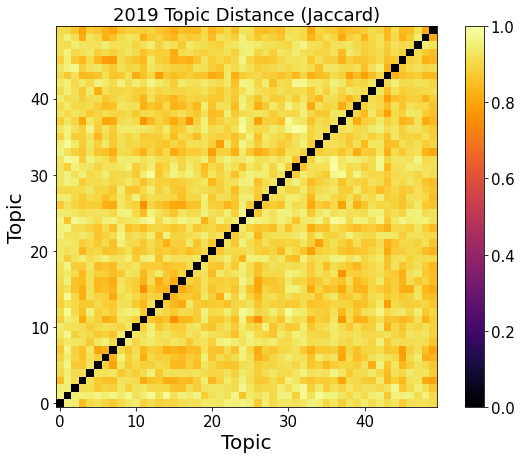

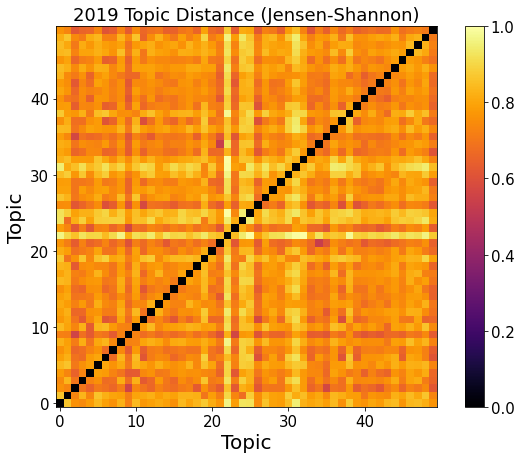

In [35]:
#checking distance from a model to itself
#jaccard
plot_difference_matplotlib(lda_by_year['2019'].diff(lda_by_year['2019'],distance="jaccard")[0],"2019 Topic Distance (Jaccard)")

#shannon-jensen
plot_difference_matplotlib(lda_by_year['2019'].diff(lda_by_year['2019'],distance="jensen_shannon")[0],"2019 Topic Distance (Jensen-Shannon)")

In [36]:
jaccard_topic_difference = {} 
jensen_shannon_topic_difference = {} 

for year in range(2000,2021):
    print(f"getting difference for year: {year}")
    #get forward difference between topics
    mdiff,annotations = lda_by_year[str(year+1)].diff(lda_by_year[str(year)],distance='jaccard',num_words=50)
    jaccard_topic_difference[year] = mdiff

    mdiff,annotations = lda_by_year[str(year+1)].diff(lda_by_year[str(year)],distance='jensen_shannon',num_words=50)
    jensen_shannon_topic_difference[year] = mdiff

getting difference for year: 2000
getting difference for year: 2001
getting difference for year: 2002
getting difference for year: 2003
getting difference for year: 2004
getting difference for year: 2005
getting difference for year: 2006
getting difference for year: 2007
getting difference for year: 2008
getting difference for year: 2009
getting difference for year: 2010
getting difference for year: 2011
getting difference for year: 2012
getting difference for year: 2013
getting difference for year: 2014
getting difference for year: 2015
getting difference for year: 2016
getting difference for year: 2017
getting difference for year: 2018
getting difference for year: 2019
getting difference for year: 2020


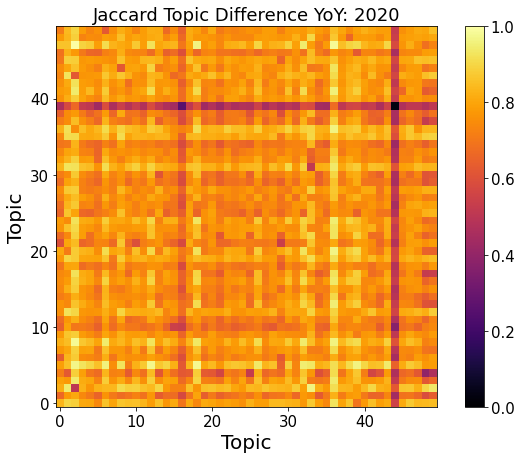

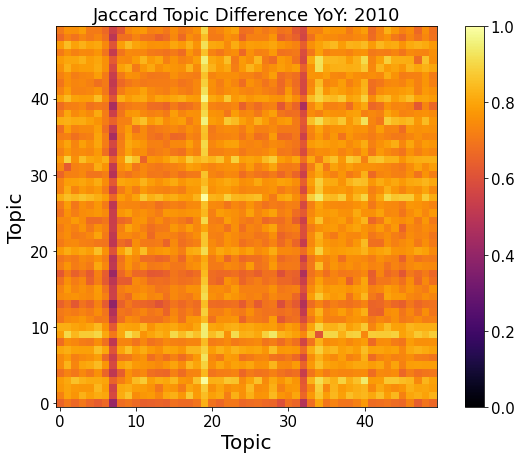

In [63]:
#plot difference in topics over time
year = 2020
plot_difference_matplotlib(jensen_shannon_topic_difference[year], title=f"Jaccard Topic Difference YoY: {year}")


year = 2010
plot_difference_matplotlib(jensen_shannon_topic_difference[year], title=f"Jaccard Topic Difference YoY: {year}")

In [57]:
def metric_by_year(data_dict,title=''):
    xs = sorted(list(data_dict.keys()))
    ys = [data_dict[x].sum()/(ntopics**2) for x in xs]

    fig = plt.figure(figsize=(8, 6))

    plt.scatter(xs,ys,s=100)
    plt.xlabel('Year',fontsize=20)
    plt.ylabel('Sum of Differences',fontsize=20)
    plt.title(title)
    plt.xticks(xs,[str(x) for x in xs],rotation='vertical')


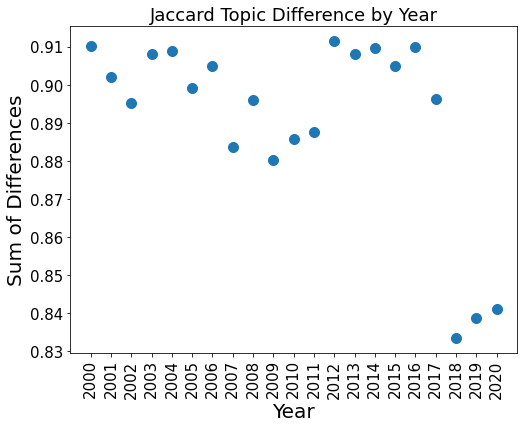

In [58]:
#plot difference in topics over time
metric_by_year(jaccard_topic_difference,'Jaccard Topic Difference by Year')


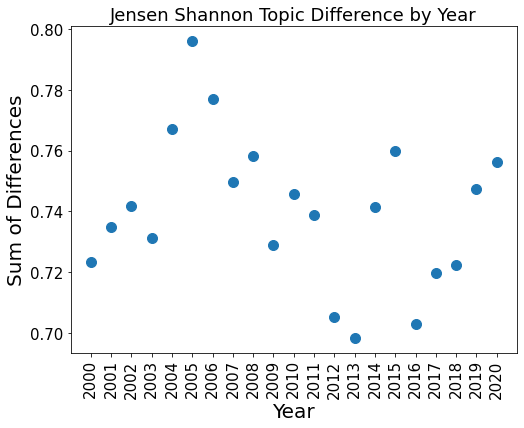

In [59]:
metric_by_year(jensen_shannon_topic_difference,'Jensen Shannon Topic Difference by Year')

From the plot on Jaccard distances, it appears that the language in these abstracts has become slightly more homogeneous around 2018.

### Funding Per Topic

In [40]:
year = '2020'
topic_dist = lda_by_year[year].get_document_topics(corpus_by_year[year],minimum_probability=0)

In [42]:
lda_by_year['2007'].show_topics(num_topics=ntopics,num_words=8,formatted=True)[:10]

[(0,
  '0.011*"element" + 0.011*"performance" + 0.009*"material" + 0.008*"quality" + 0.007*"industry" + 0.007*"test" + 0.007*"manufacturing" + 0.007*"finite"'),
 (1,
  '0.010*"stability" + 0.009*"structure" + 0.008*"application" + 0.007*"graduate" + 0.007*"nanostructures" + 0.007*"cell" + 0.007*"goal" + 0.007*"composite"'),
 (2,
  '0.010*"friction" + 0.009*"technology" + 0.009*"mechanical" + 0.007*"surface" + 0.007*"defect" + 0.007*"material" + 0.006*"device" + 0.006*"structure"'),
 (3,
  '0.014*"process" + 0.009*"motion" + 0.009*"network" + 0.008*"building" + 0.007*"block" + 0.006*"task" + 0.006*"tissue" + 0.006*"stochastic"'),
 (4,
  '0.012*"patient" + 0.011*"nehrp" + 0.010*"clinic" + 0.007*"mechanical" + 0.007*"data" + 0.007*"scheduling" + 0.007*"lipid" + 0.007*"hot"'),
 (5,
  '0.016*"conflict" + 0.013*"resolution" + 0.012*"process" + 0.011*"industry" + 0.009*"cell" + 0.009*"technique" + 0.008*"mechanical" + 0.008*"tissue"'),
 (6,
  '0.013*"decision" + 0.011*"performance" + 0.010*"p

In [43]:
#funding per topic for each year
def funding_per_topic(data,lda_by_year,year):
    #get topic distribution for each abstract
    topic_dist = lda_by_year[year].get_document_topics(corpus_by_year[year],minimum_probability=0)


In [44]:
for year in sorted(lda_by_year.keys()):
    print(f'{year}: npred: {len(lda_by_year[year].get_document_topics(corpus[-1]))}')

2000: npred: 14
2001: npred: 17
2002: npred: 16
2003: npred: 13
2004: npred: 13
2005: npred: 16
2006: npred: 16
2007: npred: 13
2008: npred: 16
2009: npred: 12
2010: npred: 14
2011: npred: 13
2012: npred: 13
2013: npred: 14
2014: npred: 13
2015: npred: 14
2016: npred: 13
2017: npred: 14
2018: npred: 14
2019: npred: 10
2020: npred: 50
2021: npred: 3


In [45]:
lda_by_year['2019'].get_document_topics(corpus[-1])

[(7, 0.024651866),
 (10, 0.047316525),
 (14, 0.012052963),
 (16, 0.046102025),
 (28, 0.12652528),
 (30, 0.30500957),
 (34, 0.10716791),
 (40, 0.04221632),
 (43, 0.05911585),
 (44, 0.10869089),
 (48, 0.11883578)]

In [46]:
#split award amounts in a similar fashion to corpus
funding_by_year = {}
for year in data['year'].unique():
    funding_by_year[year] = [data.loc[i,'amount'] for i in data[data['year']==year].index]

In [47]:
#get funding per topic for a specifc year
year = '2005'
model = lda_by_year[year]

total_funding = [0]*model.num_topics
#for each doc in that corpus, get the topic distribution and multiply by the funding amount
for i,doc in enumerate(corpus_by_year[year]):
    topic_dist = model.get_document_topics(doc) #[(topic,pr)]
    for topic,pr in topic_dist:
        total_funding[topic] += pr*float(funding_by_year[year][i])

In [48]:
sum(total_funding)

150868784.5791995

In [49]:
data[data['year']==year]['amount'].apply(float).sum()

151537068.0

In [50]:
#troubleshooting why sums are different
for i,doc in enumerate(corpus_by_year[year]):
    topic_dist = model.get_document_topics(doc) #[(topic,pr)]
    docsum = 0
    for topic,pr in topic_dist:
        docsum+=pr
    if docsum!=1:
        print("i: ",i," docsum: ",docsum)


i:  0  docsum:  0.9944660663604736
i:  1  docsum:  0.9959241151809692
i:  2  docsum:  0.9962204247713089
i:  3  docsum:  0.9938474297523499
i:  4  docsum:  0.9960874319076538
i:  5  docsum:  0.9956701397895813
i:  6  docsum:  0.9952342510223389
i:  7  docsum:  0.9957360029220581
i:  8  docsum:  0.9947460889816284
i:  9  docsum:  0.9960637092590332
i:  10  docsum:  0.9957931339740753
i:  11  docsum:  0.9952724575996399
i:  12  docsum:  0.9951393604278564
i:  13  docsum:  0.9951393604278564
i:  14  docsum:  0.9956472516059875
i:  15  docsum:  0.996229887008667
i:  16  docsum:  0.9952723383903503
i:  17  docsum:  0.9968668222427368
i:  18  docsum:  0.9932544827461243
i:  19  docsum:  0.9959700927138329
i:  20  docsum:  0.996229887008667
i:  21  docsum:  0.9942728281021118
i:  22  docsum:  0.9962221384048462
i:  23  docsum:  0.9951096773147583
i:  24  docsum:  0.9952724575996399
i:  25  docsum:  0.9962323904037476
i:  26  docsum:  0.9945198893547058
i:  27  docsum:  0.9968198239803314
i:  

Only a small loss of precision (probabilities don't always sum to 1). This is insignificant so we will ignore for now.

In [51]:
#wrap into function 
def funding_per_topic(corpus,model,funding):
    total_funding = [0]*model.num_topics
    for i,doc in enumerate(corpus):
        topic_dist = model.get_document_topics(doc) 
        for topic,pr in topic_dist:
            total_funding[topic] += pr*float(funding[i])
    return total_funding

In [52]:
total_funding_year = dict()
for year in data['year'].unique():
    print(f'working on year: {year}')
    total_funding_year[year] = funding_per_topic(corpus_by_year[year], lda_by_year[year], funding_by_year[year])

working on year: 2000
working on year: 2001
working on year: 2002
working on year: 2003
working on year: 2004
working on year: 2005
working on year: 2006
working on year: 2007
working on year: 2008
working on year: 2009
working on year: 2010
working on year: 2011
working on year: 2012
working on year: 2013
working on year: 2014
working on year: 2015
working on year: 2016
working on year: 2017
working on year: 2018
working on year: 2019
working on year: 2020
working on year: 2021


In [53]:
#visualize funding per topic
def funding_per_topic_plot(yearly_funding,year:str):
    total_funding = yearly_funding[year]
    num_topics = len(yearly_funding[year])

    plt.bar(x=range(0,50), height=sorted(total_funding/sum(total_funding),reverse=True), color='blue', label='Topic Funding')

    #average funding per topic
    plt.plot(range(-1,num_topics+1), [1/num_topics for i in range(-1,num_topics+1)], color='red',label='Average Funding')

    plt.xlabel('Topic')
    plt.ylabel('Funding Proportion')
    plt.title(f'Funding per Topic for {year}')
    plt.legend(loc='upper right')



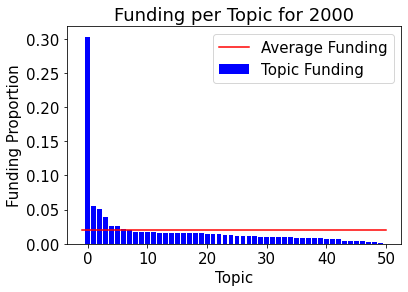

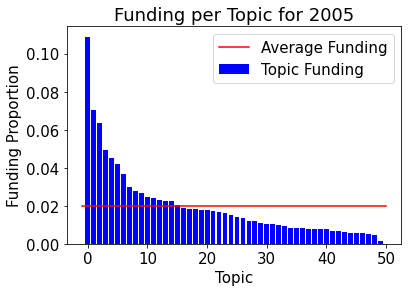

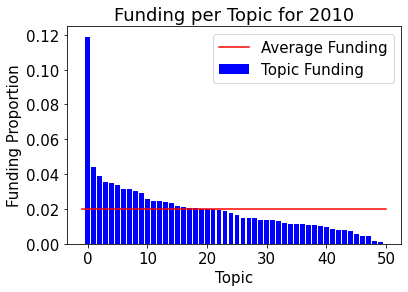

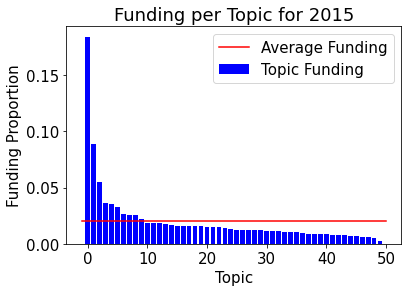

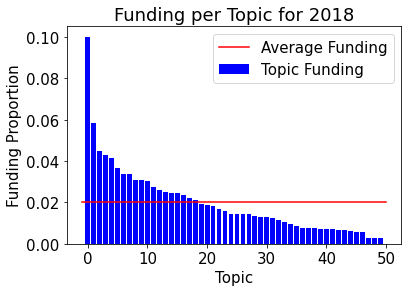

In [54]:
plt.show(funding_per_topic_plot(total_funding_year,'2000'))

plt.show(funding_per_topic_plot(total_funding_year,'2005'))

plt.show(funding_per_topic_plot(total_funding_year,'2010'))

plt.show(funding_per_topic_plot(total_funding_year,'2015'))

plt.show(funding_per_topic_plot(total_funding_year,'2018'))

Over the years, it appears that funding for topics is less heavy tailed. One way to quantify this and do away with individual plots would be to look at the entropy of this distribution. Higher entropy would indicate larger uniformity in topic funding.

In [55]:
def entropy(x:list):
    """Calculates the entropy of a list of values"""
    x = np.array(x)
    x = x[x > 0]
    x = x / np.sum(x)
    return -np.sum(x * np.log(x))


def normalized_entropy(x:list):
    """Calculates normalized entropy by dividing by the maximum entropy for non-zero values"""
    x = np.array(x)
    x = x[x > 0]
    x = x / np.sum(x)
    return -np.sum(x * np.log(x)) / np.log(len(x))

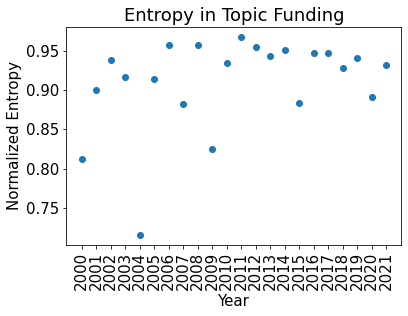

In [56]:
#ploting entropy
plt.scatter([str(x) for x in range(2000,2022)],[normalized_entropy(total_funding_year[str(x)]) for x in range(2000,2022)])
plt.xlabel('Year')
plt.ylabel('Normalized Entropy')
plt.title('Entropy in Topic Funding')
plt.xticks(rotation=90)
plt.show()